#SIML Assignment 1  
Georgy Andryushchenko

In this assignment I have decided to implement a face recognition siamese convolutional neural network in Tensorflow framework. As an input it is going to take two images. One of the images(of 250x250 size) should contain a face of a person that we want to recognize. Another image contains a face of a person that should be in the first image in order to be recognized.

I've decided to implement the neural network architecture for object recognition described [here](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf). Due to the fact that I have really little experience in working with convolutional neural networks I've used some parts of the code from [this tutorial](https://www.youtube.com/watch?v=LKispFFQ5GU&t=12927s).

The dataset for the model was prepared by me. It consists of pictures of me and another people. The images of another people were taken from [here](https://www.kaggle.com/jessicali9530/lfw-dataset).

In [ ]:
# import necessary modules and classes
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
# check if the GPU is available
list(tf.config.experimental.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Let us describe the terminology that we are going to use:  
1. Anchor  
Image that contain a face that is given for recognition
2. Positive Image  
Image that contain a face of the same person as in anchors
3. Negative Image  
Image that contain a face of a different person comparing to a person in anchors

In [ ]:
# initialize paths for storing images

# images that will be similar to the input image
POS_PATH = os.path.join('faces', 'positive')

# images that will be different to the input image
NEG_PATH = os.path.join('faces', 'negative')

# input images
ANC_PATH = os.path.join('faces', 'anchor')

In [ ]:
# make the working directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# unzip negative images
!unzip drive/MyDrive/faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

In [ ]:
import shutil

# path where the unzipped directories(for each person)
# with images lay
path = 'lfw-deepfunneled/lfw-deepfunneled'

# copy the unzipped negative images 
# into the working directory with negative images
for dir in os.listdir(path):
   for file in os.listdir(os.path.join(path, dir)):
        EX_PATH = os.path.join(path, dir, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        shutil.copy(EX_PATH, NEW_PATH)

In [ ]:
# unzip anchors and positive images to anchor and positive working directories
!unzip drive/MyDrive/myimages.zip -d ./faces/

Archive:  drive/MyDrive/myimages.zip
  inflating: ./faces/anchor/a9104818-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/a914dfcc-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/a9dd441c-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/a9e20a60-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/aa1e8b2a-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/aa236302-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/aa28164a-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/aa6e75ae-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/aa732fe0-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/aaaf8288-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/abcd09e2-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/abd1ca72-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/aca43c32-9265-11ec-81e2-efa54af96e2d.jpg  
  inflating: ./faces/anchor/ace547e0-926

# Image Preprocessing

## Take Images for Preprocessing

In [ ]:
# take 50 images from each working directory
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, "*.jpg")).take(50)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, "*.jpg")).take(50)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, "*.jpg")).take(50)

## Define Preprocessing Procedure for an Image

In [ ]:
def preprocess(file_path: str):
    # read bytes of the image from the file path
    byte_img = tf.io.read_file(file_path)
    # make a tensor from the bytes
    img = tf.io.decode_jpeg(byte_img)
    # resize the tensor as 100x100x3
    img = tf.image.resize(img, (100, 100))
    # normalize
    img = img / 255.0
    return img

## Compose Labeled Dataset

In [ ]:
# compose positive samples
# list of tuples (anchor, positive, label)
positive_dataset = tf.data.Dataset.zip(
    (
        anchor,
        positive,
        tf.data.Dataset.from_tensor_slices(
            tf.ones(len(anchor))
        )
    )
)

# compose negative samples
# list of tuples (anchor, negative, label)
negative_dataset = tf.data.Dataset.zip(
    (
        anchor,
        negative,
        tf.data.Dataset.from_tensor_slices(
            tf.zeros(len(anchor))
        )
    )
)

# compose the dataset with positive and negative samples
dataset = positive_dataset.concatenate(negative_dataset)

## Split Dataset to Train and Test Datasets

In [ ]:
# define prepocessing procedure for a sample
def preprocess_sample(img1, img2, label):
    # perform preprocessing of each image and 
    # return the tuple with the preprocessed images and the label  
    return preprocess(img1), preprocess(img2), label

In [ ]:
# build dataloader pipeline
# 1. apply preprocessing for each sample
# 2. load the dataset in memory
# 3. shuffle the samples
dataset = dataset.map(preprocess_sample) \
                    .cache() \
                    .shuffle(buffer_size=1024) 

In [ ]:
# compose train dataset

# 70% from the dataset samples are training samples
train_samples_count = round(len(dataset) * 0.7)

# 1. take first 70% of the samples
# 2. compose batches of 16 images
# 3. set up prefetching of 8 images
train_dataset = dataset.take(train_samples_count) \
                        .batch(16) \
                        .prefetch(8)

In [ ]:
# test dataset

# 30% of the dataset samples are test samples
test_dataset_count = len(dataset) - train_samples_count

# 1 and 2. take the last 30% of the dataset as a test dataset
# 3. compose batches of 16 images
# 4. set up prefetching of 8 images 
test_dataset = dataset.skip(train_samples_count) \
                        .take(test_dataset_count) \
                        .batch(16) \
                        .prefetch(8)

# Model Building

## Embedding Stage

This stage allows to translate the data from the image structure to the structure suitable for the neural network

In [ ]:
# this method implements the emmbedding stage
# of the neural network described in the source
def make_embedding():
    # layer that takes a tensor of the input image
    input_layer = Input(shape=(100,100,3), name='input_image')

    # convolution layer with 64 10x10 filters and relu activation
    conv1 = Conv2D(64, (10,10), activation='relu')(input_layer)
    # max pooling layer with 64 2x2 pools
    max_pool1 = MaxPooling2D(64, (2,2), padding='same')(conv1)

    # convolution layer with 128 7x7 filters and relu activation
    conv2 = Conv2D(128, (7,7), activation='relu')(max_pool1)
    # max pooling layer with 64 2x2 pools
    max_pool2 = MaxPooling2D(64, (2,2), padding='same')(conv2)

    # convolution layer with 128 4x4 filters and relu activation
    conv3 = Conv2D(128, (4,4), activation='relu')(max_pool2)
    # max pooling layer with 64 2x2 pools
    max_pool3 = MaxPooling2D(64, (2,2), padding='same')(conv3)

    # convolution layer with 256 4x4 filters and relu activation
    conv4 = Conv2D(256, (4,4), activation='relu')(max_pool3)
    # convert result of the convolution later to one-dimensional array
    flat1 = Flatten()(conv4)
    # pass the input from flat1 neurons to the dense layer with sigmoid activation
    dense1 = Dense(4096, activation='sigmoid')(flat1)

    return Model(inputs=[input_layer], outputs=[dense1], name='embedding')

In [ ]:
# compose the stage
embedding = make_embedding()

## Distance Layer

The layer takes two tensors (anchor and positive/negative image) and composes a tensor that depicts the similarity between the images 

In [ ]:
# compose custom layer for finding the difference between two images
class L1DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # calculate the absolute error tensor from the tensors
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## Siamese Model

In [ ]:
# implements the full architecture of the siamese model
def make_siamese_model():

    # anchor image input
    input_image = Input(name='input_image', shape=(100,100,3))
    
    # positive/negative image input
    validation_image = Input(name='validation_image', shape=(100,100,3))

    # combine distance components
    dist_layer = L1DistanceLayer()
    dist_layer.__name = 'distance'
    # pass to distance layer the result of embedding stages
    # for each of the images
    distance = dist_layer(
        embedding(input_image),
        embedding(validation_image)
    )

    # classification layer
    clr = Dense(1, activation='sigmoid')(distance)

    return Model(
        inputs=[input_image, validation_image],
        outputs=[clr],
        name='SiameseModel'
    )

In [ ]:
# compose the model for recognition
siamese_model = make_siamese_model()

# Training

## Loss and Optimizer

In [ ]:
# use binary cross enthropy as a loss function
# as it was stated by the authors 
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
# use popular solver for updating the weights of the NN
optimizer = tf.keras.optimizers.Adam(1e-4)

## Build Training Loop

In [ ]:
# checkpoint_dir = os.path.join('.', 'train_checkpoints')
# checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
# checkpoint = tf.train.Checkpoint(
#     opt=optimizer,
#     siamese_model=siamese_model
# )

In [ ]:
# define the training step
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # get anchor and validation image
        X = batch[:2]
        # get the label
        y = batch[2]

        # get the training prediction
        y_pred = siamese_model(X, training=True)
        # calculate the loss
        loss = binary_cross_loss(y, y_pred)

        # calculate gradient
        gradient = tape.gradient(loss, siamese_model.trainable_variables)

        # perform backpropagation and update weights
        optimizer.apply_gradients(
            zip(gradient, siamese_model.trainable_variables)
        )

        return loss       

In [ ]:
# define the training procedure given a number of epochs
def train(data, epochs):
    for epoch in range(1, epochs+1):
        print(f'\n Epoch {epoch}/{epochs}')
        # initilize progress bar of the training
        progressbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            # apply a training step for each batch
            train_step(batch)
            # update the progress bar
            progressbar.update(idx+1)

        # save checkpoints
        # if epoch % 10 == 0:
        #     checkpoint.save(file_prefix=checkpoint_prefix)

## Train Model

In [ ]:
# train the model on the train dataset for 50 epochs
train(train_dataset, 50)


 Epoch 1/50
5/5 [==============================] - 15s 700ms/step

 Epoch 2/50
5/5 [==============================] - 3s 739ms/step

 Epoch 3/50
5/5 [==============================] - 3s 708ms/step

 Epoch 4/50
5/5 [==============================] - 3s 710ms/step

 Epoch 5/50
5/5 [==============================] - 3s 704ms/step

 Epoch 6/50
5/5 [==============================] - 3s 705ms/step

 Epoch 7/50
5/5 [==============================] - 3s 705ms/step

 Epoch 8/50
5/5 [==============================] - 3s 710ms/step

 Epoch 9/50
5/5 [==============================] - 3s 713ms/step

 Epoch 10/50
5/5 [==============================] - 3s 715ms/step

 Epoch 11/50
5/5 [==============================] - 3s 709ms/step

 Epoch 12/50
5/5 [==============================] - 3s 714ms/step

 Epoch 13/50
5/5 [==============================] - 3s 719ms/step

 Epoch 14/50
5/5 [==============================] - 3s 714ms/step

 Epoch 15/50
5/5 [==============================] - 3s 714ms/step

 E

# Evaluation

In [ ]:
# import accuracy metric (binary in our case)
from tensorflow.keras.metrics import BinaryAccuracy

In [ ]:
# get some batch from the test dataset
test_input, test_val, y_true = test_dataset.as_numpy_iterator().next()

# make predicitons and interpret the probabilities
predictions = [
    1 if item >= 0.5
    else 0
    for item in siamese_model.predict([test_input, test_val])
]

print('Predictions Per Sample:', predictions)
print('Labels Per Sample', y_true)

Predictions Per Sample: [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Labels Per Sample [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
# calculate accuracy score on a batch
acc = BinaryAccuracy()
acc.update_state(y_true, predictions)
print('Accuracy Score:', acc.result().numpy())

Accuracy Score: 1.0


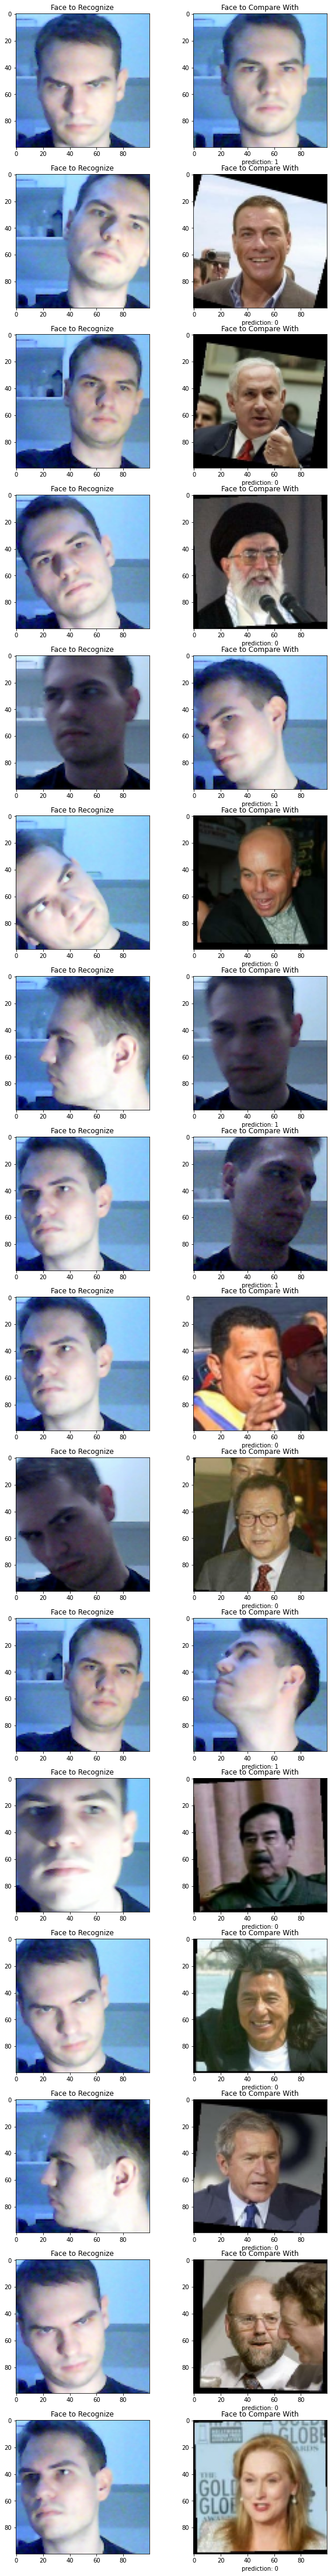

In [ ]:
# visualization of the results
fig = plt.figure(figsize=(10,80))

# get the number of predictions that were made
n_pred = len(predictions)

for i in range(n_pred):

    # for each prediction show the two input images
    # and show model's prediction

    ax = plt.subplot(n_pred, 2, 2*i+1)
    ax.set_title("Face to Recognize")
    ax.imshow(test_input[i])

    ax = plt.subplot(n_pred, 2, 2*i+2)
    ax.set_title("Face to Compare With")
    ax.set_xlabel(f'prediction: {predictions[i]}')
    ax.imshow(test_val[i])